# 使用逻辑回归实现病人用药辅助

## 实验内容

在本案例中，我们会通过分析患者的若干项医学检验指标，构建一个逻辑回归模型，预测一位患者是否有糖尿病，从而辅助医生的用药。

我们使用的数据集是患者的各项检验指数据，数据集共有9个字段，解释如下：
* BloodPressure：血压值
* SkinThickness：肱三头肌皮肤褶皱厚度
* Insulin：2小时血清胰岛素含量
* BMI：体重指数
* DiabetesPedigreeFunction：糖尿病谱系功能
* Age: 年龄
* Outcome：结果，是否有糖尿病


## 实验步骤

### 进入ModelArts界面

点击如下链接：https://www.huaweicloud.com/product/modelarts.html ，进入ModelArts主页。点击“立即使用”按钮，输入用户名和密码登录，进入ModelArts使用页面。


### 创建ModelArts Notebook

下面，我们在ModelArts中创建一个notebook开发环境，ModelArts notebook提供网页版的Python开发环境，可以方便的编写、运行代码，并查看运行结果。

第一步：在ModelArts服务主界面依次点击“开发环境”、“创建”

![create_nb_create_button](./img/create_nb_create_button.png)

第二步：填写notebook所需的参数：

| 参数 | 说明 |
| - - - - - | - - - - - |
| 计费方式 | 按需计费  |
| 名称 | Notebook实例名称，如 diabetes_prediciton_logistic_regression |
| 工作环境 | Python3 |
| 资源池 | 选择"公共资源池"即可 |
| 类型 | CPU |
| 规格 | 2核8GiB |
| 存储配置 | 选择EVS，磁盘规格5GB |

第三步：配置好notebook参数后，点击下一步，进入notebook信息预览。确认无误后，点击“立即创建”

![create_nb_creation_summary](./img/create_nb_creation_summary.png)

第四步：创建完成后，返回开发环境主界面，等待Notebook创建完毕后，打开Notebook，进行下一步操作。
![modelarts_notebook_index](./img/modelarts_notebook_index.png)

### 在ModelArts中创建开发环境

接下来，我们创建一个实际的开发环境，用于后续的实验步骤。

第一步：点击下图所示的“打开”按钮，进入刚刚创建的Notebook
![inter_dev_env](img/enter_dev_env.png)

第二步：创建一个Python3环境的的Notebook。点击右上角的"New"，然后创建 XGBoost-Sklearn 开发环境。

第三步：点击左上方的文件名"Untitled"，并输入一个与本实验相关的名称，如"diabetes_prediciton_logistic_regression"
![notebook_untitled_filename](./img/notebook_untitled_filename.png)
![notebook_name_the_ipynb](./img/notebook_name_the_ipynb.png)


### 在Notebook中编写并执行代码

在Notebook中，我们输入一个简单的打印语句，然后点击上方的运行按钮，可以查看语句执行的结果：
![run_helloworld](./img/run_helloworld.png)


开发环境准备好啦，接下来可以愉快地写代码啦！





### 初始化ModelArts SDK

In [1]:
from modelarts.session import Session
import os
session = Session()

### 准备源代码和数据

这一步准备案例所需的源代码和数据，相关资源已经保存在OBS（华为云对象存储服务）中，我们通过ModelArts SDK将资源下载到本地，并解压到当前目录下。解压后，当前目录包含src和data两个目录，分别存有源代码和数据集。

会显示下载成功的日志。

In [2]:
if not os.path.exists('./data'):
    session.download_data(bucket_path="ai-course-common-20/diabetes_prediciton/diabetes_prediciton.tar.gz", 
                          path="./diabetes_prediciton.tar.gz")

    #  使用tar命令解压资源包
    !tar xf ./diabetes_prediciton.tar.gz
    
    # 清理压缩包
    !rm -f ./diabetes_prediciton.tar.gz

Successfully download file ai-course-common-20/diabetes_prediciton/diabetes_prediciton.tar.gz from OBS to local ./diabetes_prediciton.tar.gz


### 导入工具库

matplotlib和seaborn是Python绘图工具，pandas和numpy是矩阵运算工具。

此段代码只是引入Python包，无回显（代码执行输出）。

In [3]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### 数据读取
使用pandas.read_excel(filepath)方法读取notebook中的数据文件。
* filepath：如果是在ModelArts notebook中。


此段代码无回显。

In [4]:
df = pd.read_csv('data/diabetes.csv')

### 展示样本数据

执行这段代码可以看到数据集的5个样本数据

In [5]:
df.head(5)

,Pregnancies,Glucose,BloodPressure,SkinThickness,Insulin,BMI,DiabetesPedigreeFunction,Age,Outcome
0,6,148,72,35,0,33.6,0.627,50,1
1,1,85,66,29,0,26.6,0.351,31,0
2,8,183,64,0,0,23.3,0.672,32,1
3,1,89,66,23,94,28.1,0.167,21,0
4,0,137,40,35,168,43.1,2.288,33,1


### 展示各个字段的统计值信息

调用pandas.DataFrame.describe方法，可以看到各个特征的统计信息，包括样本数、均值、标准差、最小值、1/4分位数、1/2分位数、3/4分位数和最大值。transpose是矩阵的转置运算。

In [6]:
df.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
Pregnancies,768.0,3.845052,3.369578,0.000,1.00000,3.0000,6.00000,17.00
Glucose,768.0,120.894531,31.972618,0.000,99.00000,117.0000,140.25000,199.00
BloodPressure,768.0,69.105469,19.355807,0.000,62.00000,72.0000,80.00000,122.00
SkinThickness,768.0,20.536458,15.952218,0.000,0.00000,23.0000,32.00000,99.00
Insulin,768.0,79.799479,115.244002,0.000,0.00000,30.5000,127.25000,846.00
BMI,768.0,31.992578,7.884160,0.000,27.30000,32.0000,36.60000,67.10
DiabetesPedigreeFunction,768.0,0.471876,0.331329,0.078,0.24375,0.3725,0.62625,2.42
Age,768.0,33.240885,11.760232,21.000,24.00000,29.0000,41.00000,81.00
Outcome,768.0,0.348958,0.476951,0.000,0.00000,0.0000,1.00000,1.00


### 展示各个字段的数据类型

pandas.DataFrame.info()方法可以展示各个字段的类型信息。

可以看到每个字段的类型信息。

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 9 columns):
Pregnancies                 768 non-null int64
Glucose                     768 non-null int64
BloodPressure               768 non-null int64
SkinThickness               768 non-null int64
Insulin                     768 non-null int64
BMI                         768 non-null float64
DiabetesPedigreeFunction    768 non-null float64
Age                         768 non-null int64
Outcome                     768 non-null int64
dtypes: float64(2), int64(7)
memory usage: 54.1 KB


### 统计正、负样本数量

pandas.DataFrame.groupby()方法可以分组统计每个值的数量。

可以看到0的数量是500,1的数量是268。

In [8]:
df.groupby('Outcome').size()

Outcome
0    500
1    268
dtype: int64

### 展示正、负样本数量的分布

这段代码使用matplotlib绘制条状图和饼图，展示正、负样本数量的分布。

可以看到一张条状图和一张饼图。

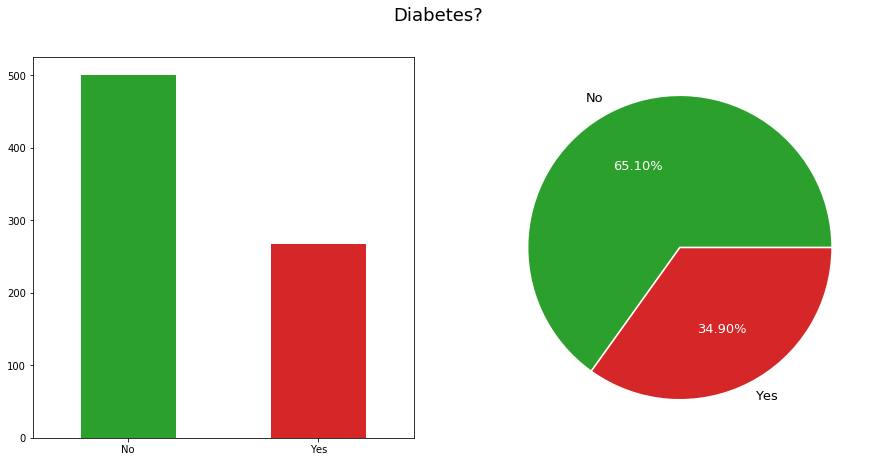

In [9]:
f, ax = plt.subplots(1, 2, figsize = (15, 7))  # figsize用来设置画布大小
f.suptitle("Diabetes?", fontsize = 18.)        # 设置图像的标题
_ = df.Outcome.value_counts().plot.bar(ax = ax[0], rot = 0, color = (sns.color_palette()[2], sns.color_palette()[3])).set(xticklabels = ["No", "Yes"])
_ = df.Outcome.value_counts().plot.pie(labels = ("No", "Yes"), autopct = "%.2f%%", label = "", fontsize = 13., ax = ax[1],\
colors = (sns.color_palette()[2], sns.color_palette()[3]), wedgeprops = {"linewidth": 1.5, "edgecolor": "white"}), ax[1].texts[1].set_color("white"), ax[1].texts[3].set_color("white")

### 展示每个特征的直方图分布

直方图是数值数据分布的精确图形表示，可以用来估计连续变量的概率分布。

可以看到每个特征的直方图分布图。

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7fcbc1aeb0f0>,
      dtype=object)

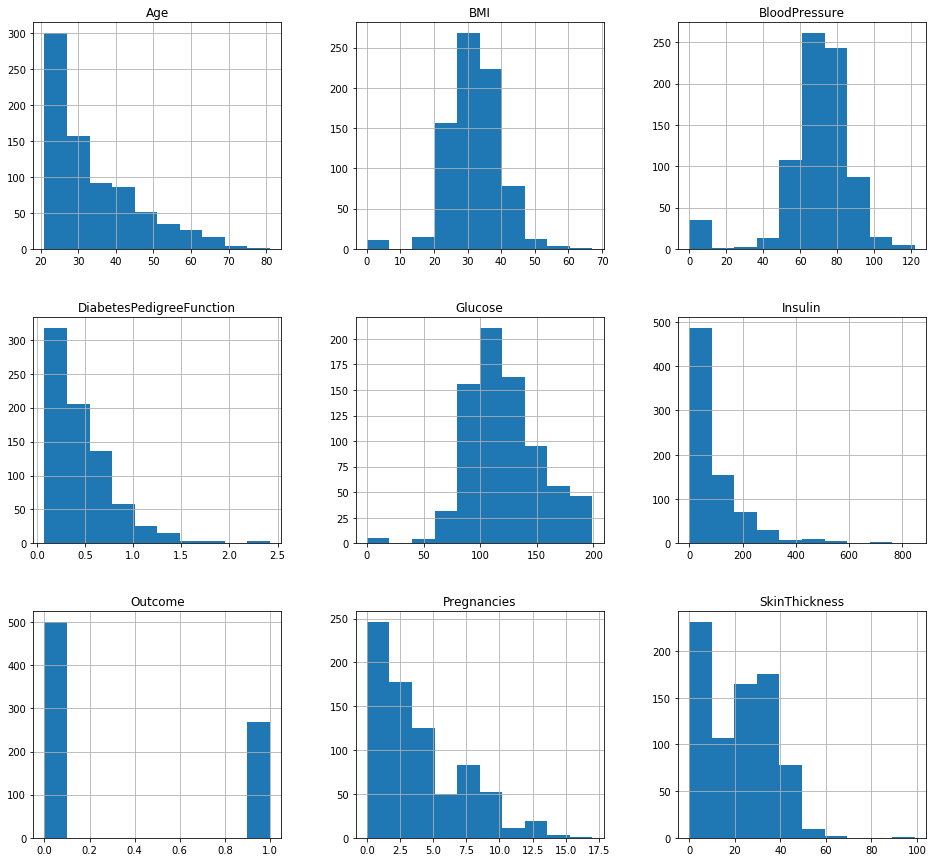

In [10]:
df.hist(figsize=(16,15))

### 观察特征之间的相关性

此段代码通过seaborn绘制热力图，展示任意两个特征之间的相关性。数值的绝对值越高说明相关性越高。

观察特征相关性的目的是，如果发现两个特征相关性很高，那么在特征选择时，可以丢弃其中的一个特征。

此段代码执行后，会有一张特征相关性热力图输出。

Text(0.5,1,'Correlation between features')

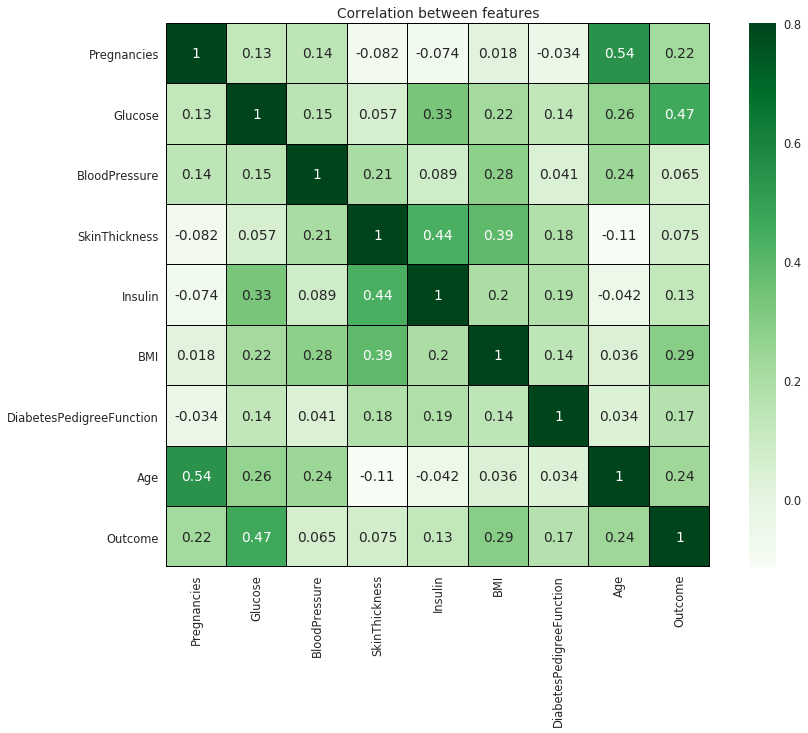

In [11]:
corr=df.corr() # 生产相关性矩阵
sns.set(font_scale=1.15) # 设置字体大小
plt.figure(figsize=(14, 10)) # 设置图像大小

# 绘制热力图
sns.heatmap(corr, vmax=.8, linewidths=0.01, square=True,annot=True,cmap="Greens",linecolor="black")
plt.title('Correlation between features')

### 特征选择

设置Outcome为预测目标。在数据分析小节中，发现各个特征并没有特别强的相关性，而且各项特征和预测目标Outcome之间的相关性也都不低，所以保留所有的特征。

此段代码无回显。

In [12]:
feature = df.drop("Outcome",axis=1) # 特征
target = df["Outcome"] # 预测目标

### 训练模型

#### 导入训练和评估工具

在糖尿病预测实验中，我们使用开源机器学习框架sklearn提供的准确率计算函数accuracy_score和数据集切分函数train_test_split。这两个方法常用于机器学习分类器的构建过程中。

此段代码无回显。

In [13]:
from sklearn.metrics import accuracy_score # 用于计算模型准确率
from sklearn.model_selection import train_test_split # 用于数据集切分

#### 切分数据集

使用train_test_split函数切分数据集，训练和测试的数据集比例是4：1。返回的X_train和y_train是训练数据的特征值和标签，X_test和y_test是测试数据的特征值和标签。

可以看到训练集的矩阵形状是(576, 8)。

In [14]:
X_train, X_test, y_train, y_test = train_test_split(feature, target, test_size=0.25, random_state=0)

print(X_train.shape)

(576, 8)


#### 使用逻辑回归算法训练模型

使用自定义的逻辑回归算法训练模型，算法源码见src目录下的logistic_regression.py文件。大家可以阅读逻辑回归分类器的源码，学习如何使用Python语言实现逻辑回归分类器。

可以看到分类器训练过程的日志打印，有训练步数，以及每步的损失值。

In [15]:
from src.logistic_regression import LogisticRegression # 导入自定义的逻辑回归算法

# 设置参数
learning_rate = 0.05  # 学习率，在梯度下降中，控制权重更新的幅度
lam = 0.01            # 参数惩罚项，为了防止过拟合

# 创建模型
LR_customized = LogisticRegression(X_train, y_train, learning_rate, lam)

# 训练模型，运行100步，并打印每个训练步的损失值。
step = 100
LR_customized.run(step, printIter=True)

Iteration 0 	cost= 0.686827383026021
Iteration 1 	cost= 0.6807756180442618
Iteration 2 	cost= 0.6749791363111561
Iteration 3 	cost= 0.6694256663270032
Iteration 4 	cost= 0.6641034265154976
Iteration 5 	cost= 0.6590011314279043
Iteration 6 	cost= 0.6541079927960338
Iteration 7 	cost= 0.6494137161819967
Iteration 8 	cost= 0.6449084939368468
Iteration 9 	cost= 0.6405829951305448
Iteration 10 	cost= 0.6364283530571244
Iteration 11 	cost= 0.6324361508557742
Iteration 12 	cost= 0.6285984057242167
Iteration 13 	cost= 0.6249075521376098
Iteration 14 	cost= 0.6213564244263141
Iteration 15 	cost= 0.6179382390101935
Iteration 16 	cost= 0.614646576536573
Iteration 17 	cost= 0.6114753641237805
Iteration 18 	cost= 0.6084188578723659
Iteration 19 	cost= 0.6054716257715006
Iteration 20 	cost= 0.602628531098368
Iteration 21 	cost= 0.5998847163831359
Iteration 22 	cost= 0.5972355879909381
Iteration 23 	cost= 0.5946768013547421
Iteration 24 	cost= 0.5922042468785533
Iteration 25 	cost= 0.58981403651873
I

#### 计算准确率

会输出逻辑回归模型的准确率。

In [16]:
y_pred_cutomized = LR_customized.predict(X_test)
print("accuracy based on logistic regression:", accuracy_score(y_test, y_pred_cutomized))

accuracy based on logistic regression: 0.7604166666666666


可以看到，准确率并不高。接下来教大家如何调节算法训练过程中的参数，来提升模型的准确率。

### 调节步数（step）

这段代码展示如何调节步数提升模型准确率，并在实验中让大家更好地理解分类器训练中步数这个概念。

这段代码逐个训练每个步数，并记录每个步数训练好之后的模型准确率。最后使用折线图显示模型准确率随着步数变化的趋势。

可以看到一张横坐标为步数，纵坐标为准确率的折线图。

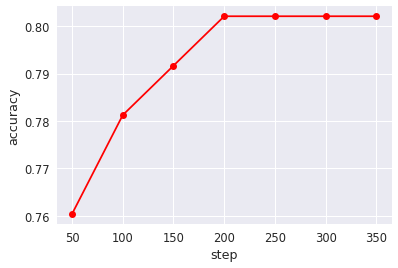

In [17]:
steps = [50, 100, 150, 200, 250, 300, 350] # 设置步数集合
acc = [] # 准确率集合

for step in steps:
    lam = 0.01  # 参数惩罚项
    learning_rate = 0.1 # 学习率
    LR_customized = LogisticRegression(X_train, y_train, learning_rate, lam)
    LR_customized.run(step, printIter=False)
    y_pred_cutomized = LR_customized.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_cutomized)
    acc.append(accuracy)

# 绘制折线图
plt.ylabel("accuracy")
plt.xlabel("step")
plt.plot(steps, acc, color='red', marker='o', linestyle='solid')
plt.show()


观察上图可以发现，训练步数从50增加到200步时，准确率是一直增加的；但是当步数从200步开始继续增加的时候，准确率就不再增加了。

说明在权重惩罚项为 0.01，学习率为0.1的情况下，训练200步就够了。训练步数表示训练的充分程度，即梯度下降的迭代次数。步数少了模型精度不能达到最优，步数太多精度也不会随着增加，是浪费时间和资源。所以选择恰当的步数，停止训练即可。

### 调节学习率（learning rate）

这段代码展示如何调节学习率提升模型准确率，并在实验中让大家更好地理解分类器训练中学习率这个概念。

这段代码逐个使用候选学习率训练300步，并记录训练完成后的模型准确率。最后使用折线图显示模型准确率随着学习率变化的趋势。

可以看到一张横坐标为学习率，纵坐标为准确率的折线图。

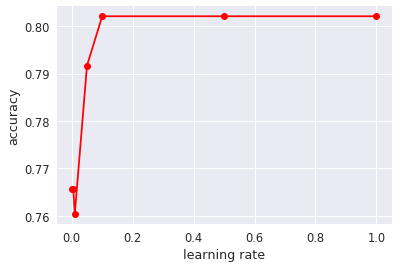

In [18]:
learning_rates = [1, 0.5, 0.1, 0.05, 0.01, 0.005, 0.001] # 设置学习率集合
acc = [] # 准确率集合

for learning_rate in learning_rates:
    lam = 0.01   # 参数惩罚项
    step = 300   # 步数
    LR_customized = LogisticRegression(X_train, y_train, learning_rate, lam)
    LR_customized.run(step, printIter=False)
    y_pred_cutomized = LR_customized.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred_cutomized)
    acc.append(accuracy)

# 绘制折线图
plt.ylabel("accuracy")
plt.xlabel("learning rate")
plt.plot(learning_rates, acc, color='red', marker='o', linestyle='solid')
plt.show()

观察上图可以发现，学习率从0.001增加到0.1的过程中，准确率是一直增加的；但是当步数从0.1继续增加的时候，准确率就不再增加了。

说明在权重惩罚项为0.01，训练300步的情况下，学习率选择0.1就够了。学习率又叫步长，步长和步数一起控制梯度下降中权重的更新，步长控制权重每步更新的幅度，步数控制权重的更新次数。步长不能太小，否则就需要训练更多的步数，才能达到最优准确率；步长也不能太大，否则可能会错过梯度下降中的最优解。

一般学习率的经验值取值范围是0.0001到0.1之间。最好的学习率设置策略是，刚开始训练时，选择稍大的值；一定步数过后，逐渐减小；接近训练结束的时候，学习率最好缩减至刚开始的100倍以上。


### 保存模型文件

我们将逻辑回归算法训练得到的模型文件保存下来，方便以后再使用。

#### 导出模型文件

训练得到模型可以导出至本地。会打印出保存的本地路径。

In [19]:
from sklearn.externals import joblib
import os

if not os.path.exists('output'):
    os.mkdir('output') # 创建本地保存路径

joblib.dump(LR_customized, "output/train_model_lr.m") # 保存

['output/train_model_lr.m']

### 小结

通过调节步长和步数这两个参数，逻辑回归分类器在糖尿病预测这个应用中，准确率能达到0.82。在糖尿病预测应用中，逻辑回归分类器不一定是最合适的，大家可以尝试使用其他的分类器，并应用调参技术，使分类器达到更高的准确率。